In [1]:
#
# Created on Thu Dec 09 2021 5:59:36 AM
# Author: Ashwin De Silva (ldesilv2@jhu.edu)
# Objective: Implements the KDN class
#

# import standard libraries
from sklearn.utils.validation import check_array, check_X_y
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt

class kdn():
    def __init__(
        self,
        network,
        k=1,
        polytope_compute_method="all",
        weighting_method="lin",
        T=2,
        c=1,
        verbose=True,
    ):
        """Kernel Density Network

        Parameters
        ----------
        network : Keras Model
            trained neural network model
        k : int, optional
            bias tuning parameter, by default 1
        polytope_compute_method : str, optional
            select the polytope compute method, by default 'all'
        T : int, optional
            polytope size threshold, by default 2
        c : int, optional
            weight tuning parameter, by default 1
        weighting : bool, optional
            select the weighting scheme, by default True
        verbose : bool, optional
            display meta data, by default True
        """

        super().__init__()
        self.polytope_means = {}
        self.polytope_cov = {}
        self.network = network
        self.k = k
        self.c = c
        self.polytope_compute_method = polytope_compute_method
        self.T = T
        self.weighting_method = weighting_method
        self.bias = {}
        self.verbose = verbose

        # total number of layers in the NN
        self.total_layers = len(self.network.layers)

        # get the layer sizes of each layer
        self.network_shape = []
        for layer in network.layers:
            self.network_shape.append(layer.output_shape[-1])

        # get the weights and biases of the trained MLP
        self.weights = {}
        self.biases = {}
        for i in range(len(self.network.layers)):
            weight, bias = self.network.layers[i].get_weights()
            self.weights[i], self.biases[i] = weight, bias.reshape(1, -1)

    def _get_polytope_memberships(self, X):
        r"""
        Obtain the polytope ID of each input sample
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        polytope_memberships = []
        last_activations = X

        # Iterate through neural network manually, getting node activations at each step
        for layer_id in range(self.total_layers):
            weights, bias = self.network.layers[layer_id].get_weights()

            # Calculate new activations based on input to this layer
            preactivation = np.matmul(last_activations, weights) + bias

            # get list of activated nodes in this layer
            if layer_id == self.total_layers - 1:
                binary_preactivation = (preactivation > 0.5).astype("int")
            else:
                binary_preactivation = (preactivation > 0).astype("int")

            if self.polytope_compute_method == "pl":
                # determine the polytope memberships only based on the penultimate layer (uncomment )
                if layer_id == self.total_layers - 2:
                    polytope_memberships.append(binary_preactivation)

            if self.polytope_compute_method == "all":
                # determine the polytope memberships only based on all the FC layers (uncomment)
                if layer_id < self.total_layers - 1:
                    polytope_memberships.append(binary_preactivation)

            # remove all nodes that were not activated
            last_activations = preactivation * binary_preactivation

        # Concatenate all activations for given observation
        polytope_obs = np.concatenate(polytope_memberships, axis=1)
        polytope_memberships = [
            np.tensordot(
                polytope_obs, 2 ** np.arange(0, np.shape(polytope_obs)[1]), axes=1
            )
        ]

        self.num_fc_neurons = polytope_obs.shape[
            1
        ]  # get the number of total FC neurons under consideration

        return polytope_memberships

    def _get_activation_pattern(self, polytope_id):
        """get the ReLU activation pattern given the polytope ID

        Parameters
        ----------
        polytope_id : int
            polytope identifier

        Returns
        -------
        ndarray
            ReLU activation pattern (binary) corresponding to the given polytope ID
        """
        binary_string = np.binary_repr(polytope_id, width=self.num_fc_neurons)[::-1]
        return np.array(list(binary_string)).astype("int")

    def unit_step(self, x):
        """Computes the unit step function output for a given input

        Parameters
        ----------
        x : ndarray
            Input array

        Returns
        -------
        ndarray
            Unit step function output of the input array
        """
        x = np.maximum(x, 0)
        x[x > 0] = 1
        return x

    def compute_weights(self, X_, polytope_id):
        """compute weights based on the global network linearity measure

        Parameters
        ----------
        X_ : ndarray
            Input data matrix
        polytope_id : int
            refernce polytope identifier

        Returns
        -------
        ndarray
            weights of each input sample in the input data matrix
        """
        
        M_ref = self._get_activation_pattern(polytope_id)

        start = 0
        A = X_
        A_ref = X_
        d = 0
        for l in range(len(self.network_shape)-1):
            end = start + self.network_shape[l]
            M_l = M_ref[start:end]
            start = end
            W, B = self.weights[l], self.biases[l]
            pre_A = A @ W + B
            A = np.maximum(0, pre_A)
            pre_A_ref = A_ref @ W + B
            A_ref = pre_A_ref @ np.diag(M_l) 
            d += np.linalg.norm(A - A_ref, axis=1, ord=2)

        return np.exp(-self.c * d)

    def fit(self, X, y):
        r"""
        Fits the kernel density network
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        y : ndarray
            Output (i.e. response) data matrix.
        """
        X, y = check_X_y(X, y)
        self.labels = np.unique(y)

        feature_dim = X.shape[1]

        mean_fractions = []
        for label in self.labels:
            self.polytope_means[label] = []
            self.polytope_cov[label] = []

            X_ = X[np.where(y == label)[0]]
            polytope_memberships = self._get_polytope_memberships(X_)[0]
            unique_polytope_ids = np.unique(
                polytope_memberships
            )  # get the unique polytopes

            if self.verbose:
                print("Number of Polytopes : ", len(polytope_memberships))
                print("Number of Unique Polytopes : ", len(unique_polytope_ids))

            fractions = []  # store the polytope member counts

            for (
                idx
            ) in range(
                len(polytope_memberships)
            ):  # fit Gaussians for each unique non-singleton polytopes

                if self.weighting_method == "lin":
                    # compute weights of the input data samples w.r.t reference polytope
                    weights = self.compute_weights(X_, polytope_memberships[idx])
                elif self.weighting_method == "fm":
                    ########### FM (will be depricated) ################
                    a_native = self._get_activation_pattern(polytope_memberships[idx])
                    weights = []
                    for member_polytope_id in polytope_memberships:
                        a_foreign = self._get_activation_pattern(member_polytope_id)

                        match_status = a_foreign == a_native
                        match_status = match_status.astype("int")

                        if len(np.where(match_status == 0)[0]) == 0:
                            weight = 1.0
                        else:
                            first_mismatch_idx = np.where(match_status == 0)[0][0]
                            weight = first_mismatch_idx / self.num_fc_neurons

                        weights.append(weight)
                    weights = np.array(weights)
                ########### FM (will be depricated) ################
                else:
                    weights = np.zeros((X_.shape[0],))
                    weights[polytope_memberships == polytope_memberships[idx]] = 1

                weights[weights < 1e-3] = 0  # set very small weights to zero

                idx = np.where(weights > 0)[0]

                polytope_size = len(idx)
                fractions.append(polytope_size/len(X_))

                if (
                    polytope_size < self.T
                ):  # eliminate polytopes with too few samples within
                    continue

                scales = weights[idx] / np.max(weights[idx])

                # apply weights to the data
                X_tmp = X_[idx].copy()
                polytope_mean_ = np.average(
                    X_tmp, axis=0, weights=scales
                )  # compute the weighted average of the samples
                X_tmp -= polytope_mean_  # center the data

                sqrt_scales = np.sqrt(scales).reshape(-1, 1) @ np.ones(
                    feature_dim
                ).reshape(1, -1)
                X_tmp *= sqrt_scales  # scale the centered data with the square root of the weights

                # compute the covariance matrix of the underlying Gaussian using Ledoit-Wolf estimator

                covariance_model = LedoitWolf(assume_centered=True)
                covariance_model.fit(X_tmp)
                polytope_cov_ = covariance_model.covariance_ * len(scales) / sum(scales)

                # store the mean and covariances
                self.polytope_means[label].append(polytope_mean_)
                self.polytope_cov[label].append(polytope_cov_)

            mean_fractions.append(np.mean(fractions))

        return mean_fractions

            # ## calculate bias for each label
            # likelihoods = np.zeros((np.size(X_, 0)), dtype=float)

            # for polytope_idx, _ in enumerate(self.polytope_means[label]):
            #     likelihoods += np.nan_to_num(self._compute_pdf(X_, label, polytope_idx))

            # likelihoods /= X_.shape[0]
            # self.bias[label] = np.min(likelihoods) / (self.k * X_.shape[0])

    def _compute_pdf(self, X, label, polytope_idx):
        """compute the likelihood for the given data

        Parameters
        ----------
        X : ndarray
            Input data matrix
        label : int
            class label
        polytope_idx : int
            polytope identifier

        Returns
        -------
        ndarray
            likelihoods
        """
        polytope_mean = self.polytope_means[label][polytope_idx]
        polytope_cov = self.polytope_cov[label][polytope_idx]

        var = multivariate_normal(
            mean=polytope_mean, cov=polytope_cov, allow_singular=True
        )

        likelihood = var.pdf(X)
        return likelihood

    def predict_proba(self, X):
        r"""
        Calculate posteriors using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        likelihoods = np.zeros((np.size(X, 0), len(self.labels)), dtype=float)

        for ii, label in enumerate(self.labels):
            total_polytopes = len(self.polytope_means[label])
            for polytope_idx, _ in enumerate(self.polytope_means[label]):
                likelihoods[:, ii] += np.nan_to_num(
                    self._compute_pdf(X, label, polytope_idx)
                )

            likelihoods[:, ii] = likelihoods[:, ii] / total_polytopes
            likelihoods[:, ii] += min(self.bias.values())

        proba = (likelihoods.T / (np.sum(likelihoods, axis=1) + 1e-100)).T
        return proba

    def predict_proba_nn(self, X):
        r"""
        Calculate posteriors using the vanilla NN
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        proba = self.network.predict(X)
        return proba

    def predict(self, X):
        r"""
        Perform inference using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        return np.argmax(self.predict_proba(X), axis=1)


In [7]:
from tensorflow import keras
from kdg.utils import generate_spirals
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Define NN parameters
X_val, y_val = generate_spirals(500, noise=0.8, n_class=2)
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4),
}
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=True)
fit_kwargs = {
    "epochs": 300,
    "batch_size": 64,
    "verbose": False,
    "validation_data": (X_val, keras.utils.to_categorical(y_val)),
    "callbacks": [callback],
}

In [5]:
# define the network architecture
def getNN():
    network_base = keras.Sequential()
    initializer = keras.initializers.GlorotNormal(seed=0)
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer, input_shape=(2,)))
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(5, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(units=2, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [6]:
sample_sizes = [10, 50, 100, 500, 1000, 5000, 10000]
fractions = []
for n in sample_sizes:
    # create training, validation, and testing data
    X, y = generate_spirals(n, noise=0.8, n_class=2)

    # train Vanilla NN
    nn = getNN()
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

    model_kdn = kdn(
        network=nn,
        polytope_compute_method='all',
        weighting_method='lin',
        k=1e-5,
        c=1, 
        verbose=False
    )
    mean_fractions = model_kdn.fit(X, y)
    print(mean_fractions)
    fractions.append(mean_fractions[0])

Epoch 00245: early stopping
[1.0, 1.0]
Epoch 00208: early stopping
[1.0, 0.9952000000000001]
Epoch 00011: early stopping
[1.0, 1.0]
Epoch 00143: early stopping
[0.9974879999999999, 0.9933919999999999]
[0.7754319999999999, 0.7603800000000001]
Epoch 00179: early stopping
[0.3694912, 0.39666336]
Epoch 00129: early stopping
[0.34009652, 0.28146935999999995]


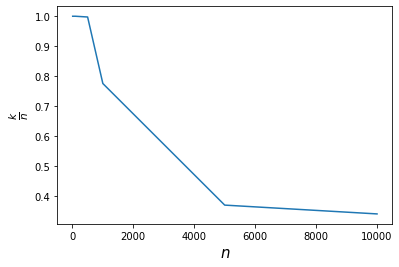

In [13]:
fig, ax = plt.subplots()
ax.plot(sample_sizes, fractions)
ax.set_xlabel(r"$n$", fontsize=15)
ax.set_ylabel(r"$\frac{k}{n}$", fontsize=15)
# ax.set_xscale("log")
plt.show()